# Graded Challange 7

## 1. Perkenalan

Nama : Adhy Arya Hendrata    
Batch : BSD 005   
Dataset : [RiceField](https://www.kaggle.com/datasets/muratkokludataset/rice-image-dataset/data)   
Huggingface : [PrediksiBeras](https://huggingface.co/spaces/adhyarya51/ComputerVisionBeras)   
Object : Membuat model computer vision, dan melakukan deployment.

### Problem Statement :

Melakukan klasifikasi beras dan prediksi gambar dengan Computer Vision.

### Latar Belakang

Beras adalah salah satu makanan pokok di dunia, Namun menjadi salah satu paling penting khususnya Benua Asia, dikarenakan tempat beras menjadi makanan pokok untuk mayoritas penduduk(terutama di kalangan menengah kebawah masyarakat). Benua Asia sendiri menjadi tempat tinggal petani, dapat diperkirakan 90% produksi beras oleh petani beras.  

Namun beras tidak memiliki satu tipe beras, melainkan berbagai macam tipe beras. Klasifikasi beras ternyata memiliki pengaruh pada setiap iklimnya masing - masing negara. Maka dari itu dibutuh model, atau deep learning computer vision untuk mempelajari jenis - jenis beras.

Pada Kasus ini akan menggunakan data beras yang terdiri dari lima kelas. Kelas masing - masing beras terdiri dari karacadag,ipsala,jasmine,arborio,dan basmati. Harapannya dengan pembentukan model, Hasil deployment dapat melakukan identifikasi beras tentunya menentukan kelima beras tersebut.


## 2. Import Libraries

In [95]:
# Import libraries
from google.colab import drive
import os
import cv2
import glob
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from collections import defaultdict
import tensorflow as tf

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, Input

from sklearn.metrics import confusion_matrix, classification_report
import warnings
warnings.filterwarnings('ignore')

## 3. Data Loading

In [ ]:
# Melakukan koneksi ke Google Drive
drive.mount('/content/drive')

# Menentukan alur folder
drive_path = '/content/drive/My Drive/Rice_Image_Dataset'

# memeriksa apabila alur sudah terdaftar pada list files
if os.path.exists(drive_path):
    print(f"Path exists: {drive_path}")
    print("Files in the dataset directory:")
    print(os.listdir(drive_path))
else:
    print(f"Path does not exist: {drive_path}")

Mounted at /content/drive
Path exists: /content/drive/My Drive/Rice_Image_Dataset
Files in the dataset directory:
['validation', 'training']


In [ ]:
# menentukan alur

main_path = '/content/drive/MyDrive/Rice_Image_Dataset'
train_path = os.path.join(main_path, 'training')

test_path = os.path.join(main_path, 'validation')


In [ ]:
# melakukan pemeriksaan fungsi
def check_path(path):
    try:
        # list hanya untuk direktori yang diberikan alur
        labels = [label for label in os.listdir(path) if os.path.isdir(os.path.join(path, label))]
        for label in labels:
            label_path = os.path.join(path, label)
            num_data = len([f for f in os.listdir(label_path) if os.path.isfile(os.path.join(label_path, f))])
            print(f'Total Data - {label} : {num_data}')
    except Exception as e:
        print(f'Error accessing path {path}: {e}')

print('Train Path')
check_path(train_path)
print('')

print('Test Path')
check_path(test_path)
print('')

Train Path
Total Data - karacadag : 1000
Total Data - ipsala : 1000
Total Data - jasmine : 1000
Total Data - basmati : 1000
Total Data - arborio : 1000

Test Path
Total Data - ipsala : 250
Total Data - karacadag : 250
Total Data - arborio : 250
Total Data - basmati : 250
Total Data - jasmine : 250



In [ ]:
# fungsi untuk memberikan visual kelima gambar pertama setiap kelas
def plot_images(path):
  labels = os.listdir(path)
  for label in labels:
    folder_path = os.path.join(path, label)
    fig = plt.figure(figsize=(20, 20))
    columns = 5
    rows = 1
    print('Class : ', label)
    images = os.listdir(folder_path)
    for index in range(1, columns*rows +1):
        fig.add_subplot(rows, columns, index)
        image = plt.imread(os.path.join(folder_path, images[index]))
        plt.imshow(image)
        plt.axis("off")
    plt.show()

Hasil Observasi :
dari beberapa langkah saya lakukan adalah :  
- melakukan loading data yang dihubungkan langsung dengan google drive
- melakukan penentuan alur gambar kelas
- setelah itu menentukan bahwa total data `train` sebesar **5000**, dan `test` sebesar **1250**, sehingga total data sebanyak **6250** gambar.
- beras terdiri dari lima keals yaitu :
  `Karacadag`, `Ipsala`, `Jasmine`, `Basmati`, dan `Arborio`.


## 4. Exploratory Data Analysis (EDA)

#### Grafik batang beras

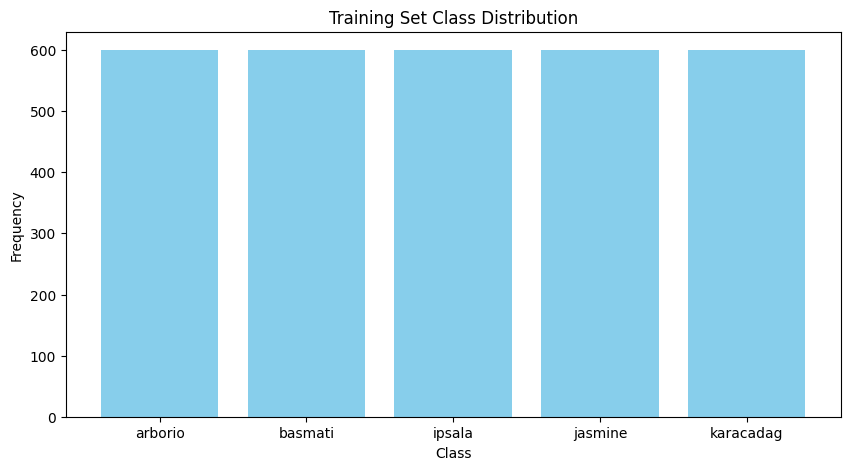

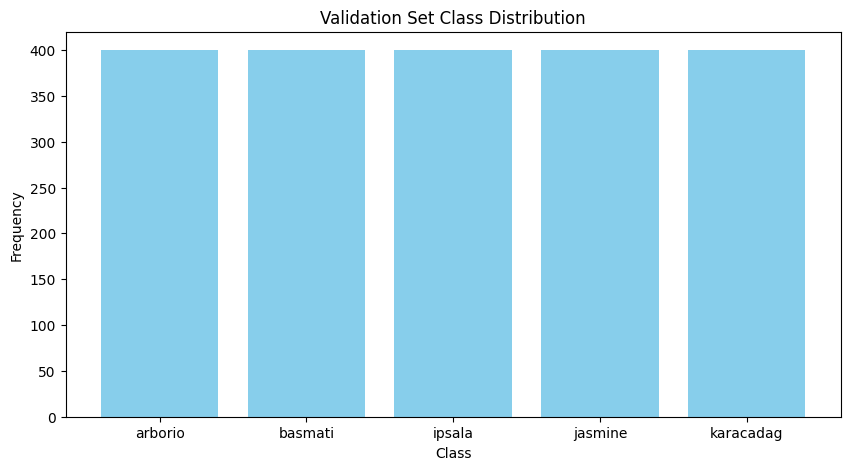

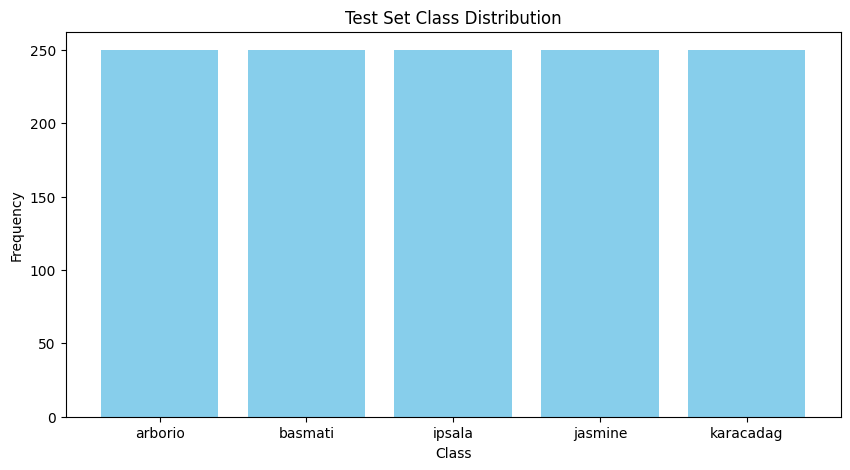

In [198]:
# membuat fungsi plot untuk menunjukan bentuk grafik
def plot_class_distribution(data_generator, title):
    class_labels = data_generator.classes
    class_names = list(data_generator.class_indices.keys())
    class_count = np.bincount(class_labels)

    plt.figure(figsize=(10, 5))
    plt.bar(class_names, class_count, color='skyblue')
    plt.xlabel('Class')
    plt.ylabel('Frequency')
    plt.title(title)
    plt.show()

plot_class_distribution(train_set, 'Training Set Class Distribution')
plot_class_distribution(val_set, 'Validation Set Class Distribution')
plot_class_distribution(test_set, 'Test Set Class Distribution')

#### Informasi bentuk Gambar

In [199]:
# memeriksa bentuk gambar yang sudah ditentukan
def check_image_shapes(data_generator):
    shapes = []
    for images, _ in data_generator:
        shapes.extend([img.shape for img in images])
        break  # hanya memeriksa batch pertama

    unique_shapes = set(shapes)
    print(f"Unique image shapes in the dataset: {unique_shapes}")

check_image_shapes(train_set)
check_image_shapes(val_set)
check_image_shapes(test_set)

Unique image shapes in the dataset: {(224, 224, 3)}
Unique image shapes in the dataset: {(224, 224, 3)}
Unique image shapes in the dataset: {(224, 224, 3)}


#### Informasi dataset,sampel,kelas, dan tipe beras.

In [200]:
# melakuka pengecheckan kelas beras , sample data, dan setiap kelasnya
def display_data_generator_info(data_generator, set_name):
    print(f"Dataset: {set_name}")
    print(f"Number of samples: {data_generator.samples}")
    print(f"Number of classes: {data_generator.num_classes}")
    print(f"Class indices: {data_generator.class_indices}")
    print("")

display_data_generator_info(train_set, "Training Set")
display_data_generator_info(val_set, "Validation Set")
display_data_generator_info(test_set, "Test Set")

Dataset: Training Set
Number of samples: 3000
Number of classes: 5
Class indices: {'arborio': 0, 'basmati': 1, 'ipsala': 2, 'jasmine': 3, 'karacadag': 4}

Dataset: Validation Set
Number of samples: 2000
Number of classes: 5
Class indices: {'arborio': 0, 'basmati': 1, 'ipsala': 2, 'jasmine': 3, 'karacadag': 4}

Dataset: Test Set
Number of samples: 1250
Number of classes: 5
Class indices: {'arborio': 0, 'basmati': 1, 'ipsala': 2, 'jasmine': 3, 'karacadag': 4}



#### Visualisasi gambar beras train, dan test path

Class :  karacadag


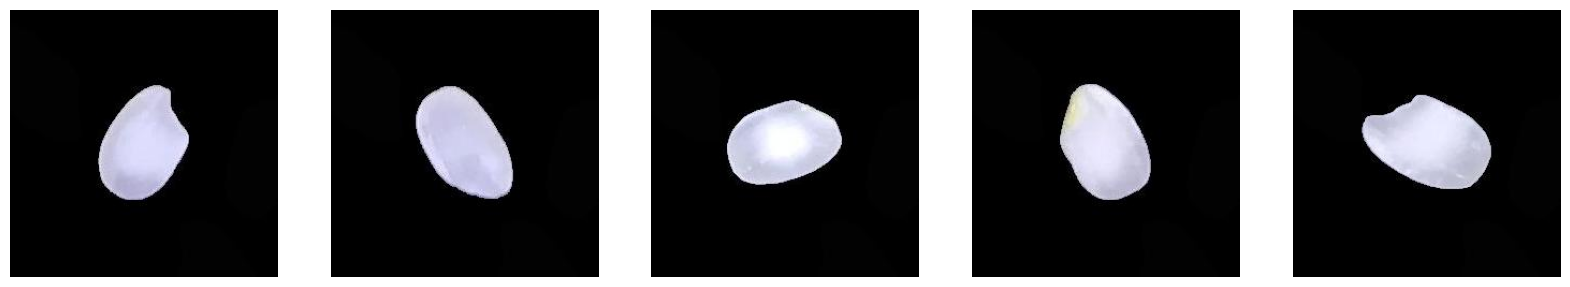

Class :  ipsala


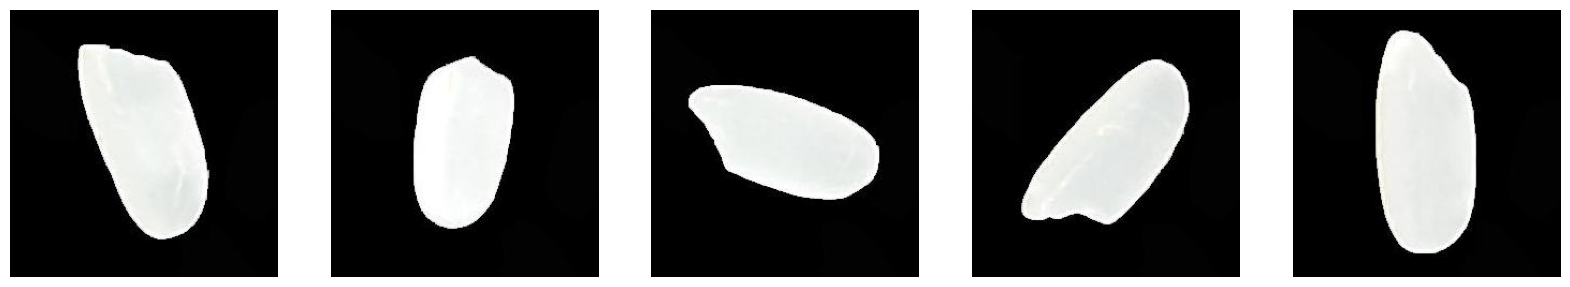

Class :  jasmine


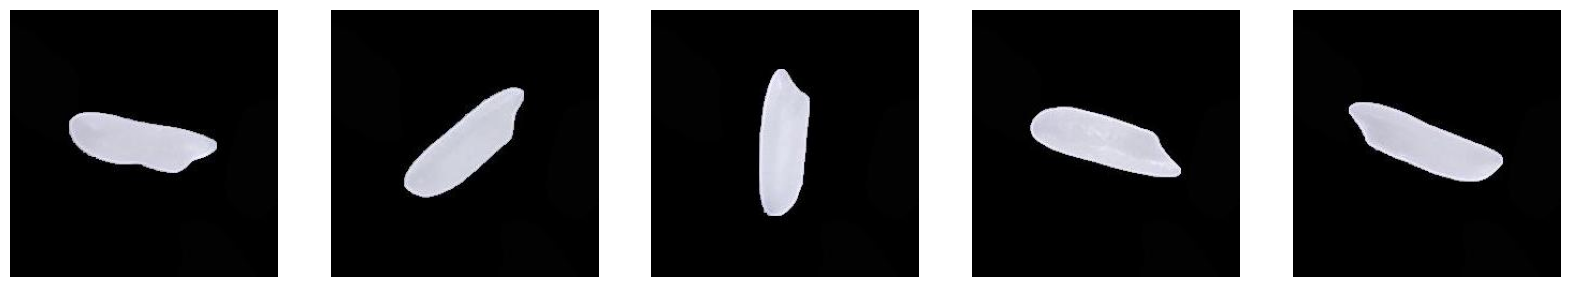

Class :  basmati


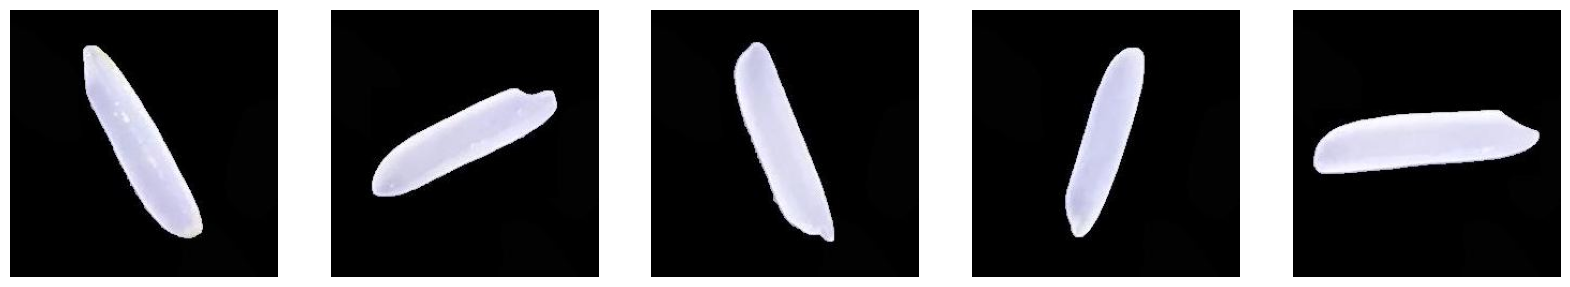

Class :  arborio


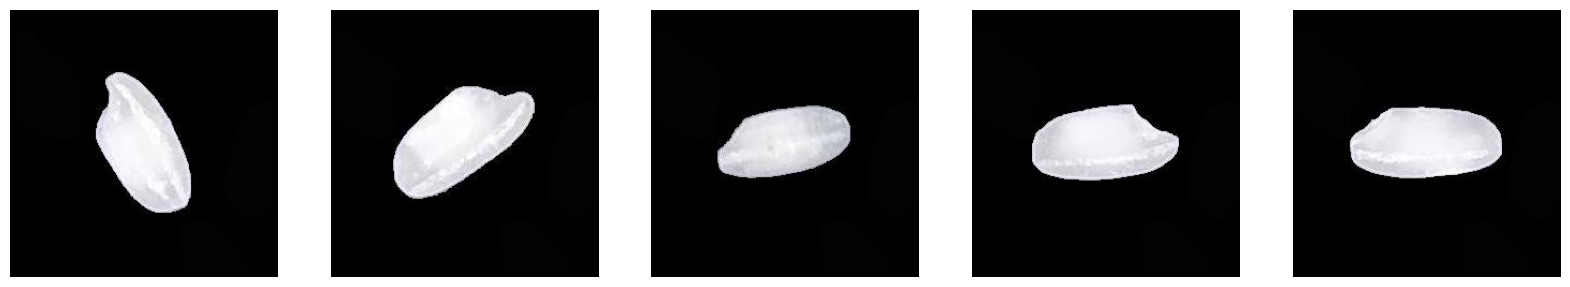

In [ ]:
# melakukan visualisasi untuk gambar 'train_path'

plot_images(train_path)

Class :  ipsala


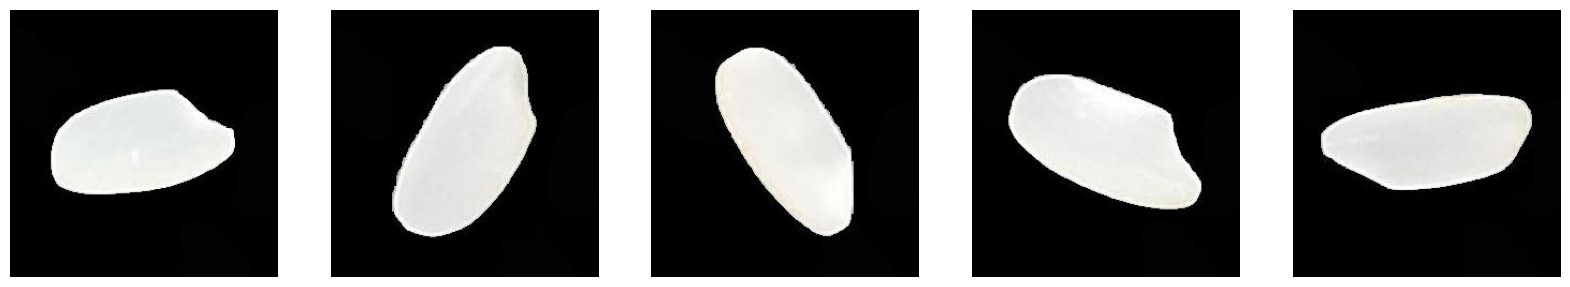

Class :  karacadag


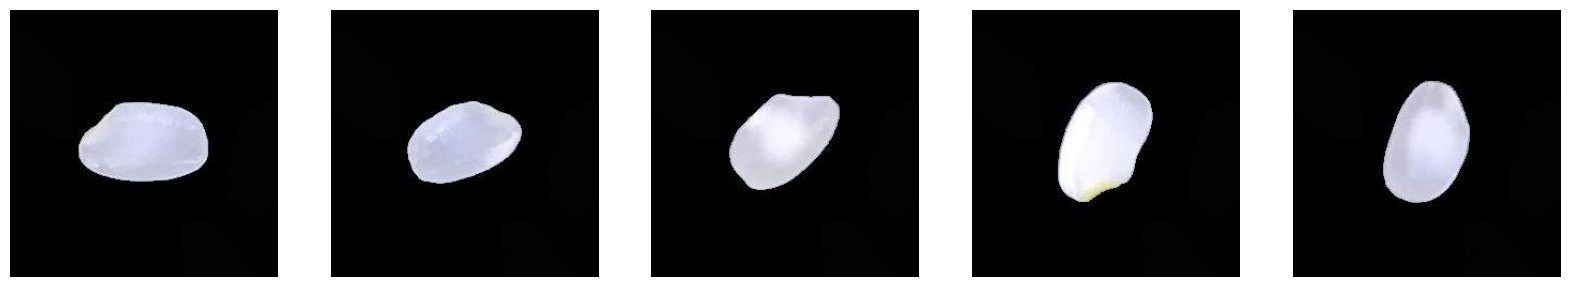

Class :  arborio


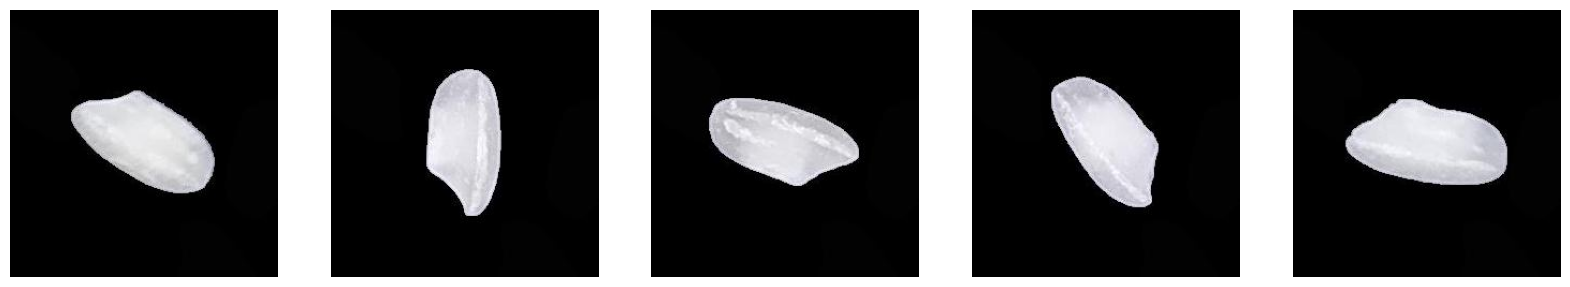

Class :  basmati


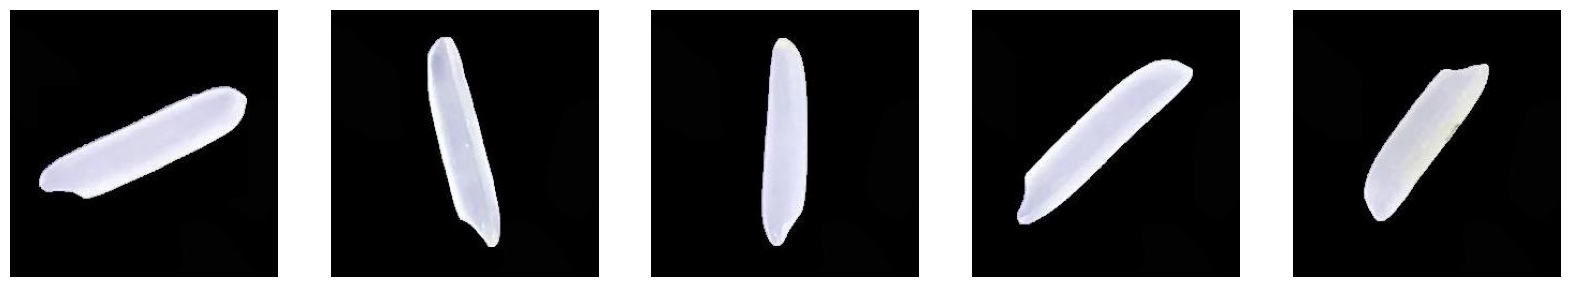

Class :  jasmine


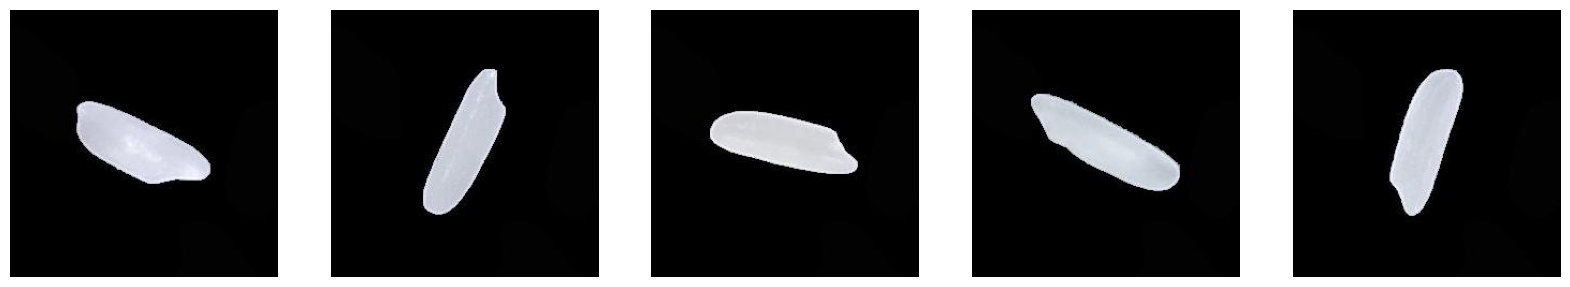

In [ ]:
# melakukan visualisasi untuk gambar `test_path`

plot_images(test_path)

#### Hasil Observasi Keseluruhan

**Grafik Batang Beras**
- bentuk grafik batang menunjukan bahwa, keseluruhan data gambar terdistribusi secara rata. Hal ini bisa menjadi persiapan dalam melakukan modeling data tidak akan ada kendala.
- sebaran data secara seimbang juga membantu memudahkan untuk melakukan training model lebih cepat.

**Informasi bentuk Gambar**
- ketiga gambar yang dipisahkan sementar dan dibentuk, masing2 memiliki bentuk yang sama yaitu panjang , dan lebar sebesar **224**. Hal ini akan menjadi acuan sebagai parameter untuk modeling.

**Informasi Dataset,Sampel,Kelas,dan tipe Beras**
- informasi yang diberikan menunjukan bahwwa akan melakukan tiga pembagian dataset yaitu : `Training`,`Validation`, dan `Test`.
- jumlah sample yang dibagi sebesar **3000**,**2000**, dan **1250**.
- memiliki lima kelas, terdiri dari : `arborio:0`,`basmati:1`,`ipsala:2`,`jasmine:3`,`karacadag:4`



**Hasil Analisis Gambar Beras untuk Train Path, dan Test Path**

**Karacadag**
- apabila dilakukan proses deskripsi beras karacadag memiliki bentuk bulat dan lebih kecil, warna beras lebih putih transparan. bentuk beras lebih kecil dari jenis beras lainnya menjadi bentuk unik yang dimiliki karacadag.

**Ipsala**
- beras ipsala memberikan jenderung warna putih lebih terang dibandingkan beras lainnya. Warna beras dimiliki lebih mendekati warna putih susu, warna putih berbeda namun masih sama dengan  kelas warna sama. Bentuk beras lebih besar apabila dibandingkan dengan lainnya. Rupa beras tidak beraturan menjadi ciri khas utama dari Ipsala.

**Jasmine**
- beras jasmine memiliki bentuk unik yaitu lebih memanjang dari kedua beras sebelumnya. Namun, ciri khas warna putih hampir sama dengan beras Karacadag. Bentuk panjang, namun kecil menjadi hal yang unik yang dapat di identifikasi.

**Basmati**
- beras basmati hampir sama dengan bentuk beras jasmine, namun ukurannya lebih panjang dan besar. Warna cenderung putih transparan. Serta bentuk panjang beras lebih sempurna, dan tidak terlihat cacat.

**Arborio**
- beras yang lebih unik dengan bentuk oval sempurna, namun beberapa contoh beras memiliki cacat cobel di setiap ujung beras nya. Warna beras lebih putih mendekati ipsala, namun tidak terlalu putih susu. Hal ini bisa dikatakan warna mendekati putih bening, dan putih susu. sehingga warna tersebut diantara bening dan susu.

**Gambaran Umum Visual pada Test Path**
- Keseluruhan gambar beras terlihat sama, walaupun poto yang diambil berbeda namun memeiliki karakteristik yang sama seperti pada gambar test path.


Hasil eksplorasi ini masih bersifat umum berdasarkan gambar pada biji beras. Hal ini lebih menjelaskan bagaimana karakteristik setiap kelas - kelas beras berbeda. Beras tersebut tidak akan terlihat berbeda, apabila melihat hanya dari jarak jauh. Namun perbedaan terlihat jelas apabila gambar dilihat secara satuan dan lebih dekat.

## 5. Feature Engginering

Karena saya menganggap data yang dimiliki terlalu besar, maka saya melakukan tahap pre processing: 

- menurunkan tinggi dan lebar gambar menjadi 224x224 dari 250x250 untuk mempermudah melatih data. Asumsi untuk ukuran tersebut sudah cukup dikarenakan limitasi alat yang dilakukan untuk melatih data.
- pengurangan batch menjadi 16 memiliki tujuan agar lebih cepat melatih.
- sebelum melakukan augmentasi, saya akan mencoba melatih model tanpa augmentasi untuk menghatui situasi model setelah ditraining. 
- Hasil yang jelek akan dilakukan tahap augmentasi, dengan melakukan lima tipe augmentasi yaitu : melkakukan `zoom`, `pemotongan`, `pelebaran`, `peninggian`, dan `membalikkan` gambar.

In [135]:
# menentukan hyperparameters

img_height= 224
img_width= 224
batch_size= 16

setelah menentukan parameter, disini melanjukan dengan membagi menjadi tiga bagian data yaitu : train, val, dan test set.

In [136]:
# membuat batch generator untuk train-set, val-set, dan test-set

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./250.,
                                                                validation_split=0.4)

train_set = train_datagen.flow_from_directory(train_path,
                                              target_size=(img_height,img_width),
                                              class_mode='sparse',
                                              subset='training',
                                              batch_size=batch_size,
                                              shuffle=True,
                                              seed=2)

val_set = train_datagen.flow_from_directory(train_path,
                                            target_size=(img_height,img_width),
                                            class_mode='sparse',
                                            subset='validation',
                                            batch_size=batch_size,
                                            shuffle=True,
                                            seed=2)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./250.)

test_set = test_datagen.flow_from_directory(test_path,
                                            target_size=(img_height,img_width),
                                            class_mode='sparse',
                                            batch_size=batch_size,
                                            shuffle=False,
                                            seed=2)

Found 3000 images belonging to 5 classes.
Found 2000 images belonging to 5 classes.
Found 1250 images belonging to 5 classes.


In [137]:
# menampilkan labels

train_set.class_indices

{'arborio': 0, 'basmati': 1, 'ipsala': 2, 'jasmine': 3, 'karacadag': 4}

dalam proses ini saya menentukan bahwa, untuk train memiliki 3000 gambar, validasi memiliki 2000 gambar, serta test memiliki 1250 gambar, dan masing  - masing data memiliki 5 kelas berbeda.

## 6. ANN Training (Sequential API)

pada tahap ini saya akan menentukan model layer, dengan hyperparameter telah ditentukan.

### 6.1 Model Definition

In [138]:
# membersihkan sesi

seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

In [139]:
# membuat model Sequential API

model = Sequential()
model.add(Conv2D(16, (3,3), activation='relu', input_shape=(img_height, img_width,3)))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(32, (3,3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(64, (3,3),activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dense(5, activation='softmax'))

# menggabungkan
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 26, 26, 64)        0

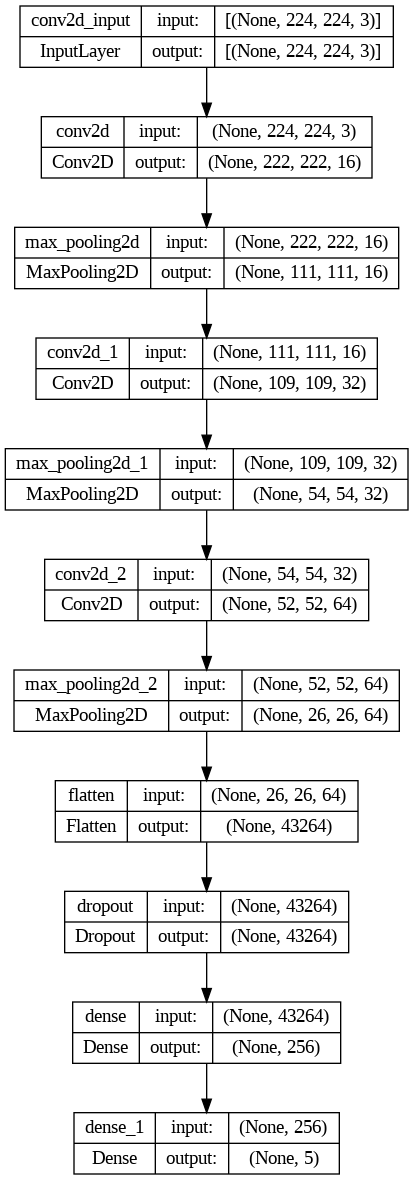

In [140]:
# Plot layers

tf.keras.utils.plot_model(model, show_shapes=True)

### 6.2 Model Training

In [ ]:
# melatih model

%%time
history = model.fit(train_set, epochs=20, validation_data=val_set, batch_size=batch_size)

Epoch 1/20
188/188 [==============================] - 1997s 11s/step - loss: 0.2295 - accuracy: 0.9177 - val_loss: 0.0891 - val_accuracy: 0.9710
Epoch 2/20
188/188 [==============================] - 15s 80ms/step - loss: 0.0685 - accuracy: 0.9767 - val_loss: 0.0893 - val_accuracy: 0.9675
Epoch 3/20
188/188 [==============================] - 15s 81ms/step - loss: 0.0550 - accuracy: 0.9790 - val_loss: 0.0776 - val_accuracy: 0.9745
Epoch 4/20
188/188 [==============================] - 15s 79ms/step - loss: 0.0402 - accuracy: 0.9853 - val_loss: 0.1311 - val_accuracy: 0.9570
Epoch 5/20
188/188 [==============================] - 15s 81ms/step - loss: 0.0400 - accuracy: 0.9837 - val_loss: 0.0964 - val_accuracy: 0.9710
Epoch 6/20
188/188 [==============================] - 15s 81ms/step - loss: 0.0291 - accuracy: 0.9903 - val_loss: 0.0979 - val_accuracy: 0.9740
Epoch 7/20
188/188 [==============================] - 15s 81ms/step - loss: 0.0220 - accuracy: 0.9940 - val_loss: 0.0946 - val_accuracy

### 6.3 Model Evaluation

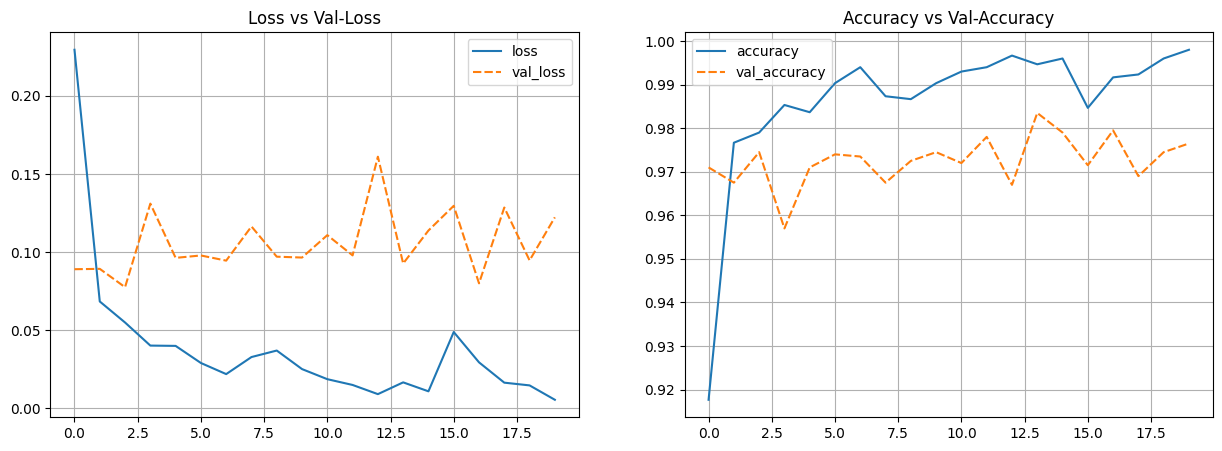

In [ ]:
# hasil plot latihan model

history_df = pd.DataFrame(history.history)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.lineplot(data=history_df[['loss', 'val_loss']])
plt.grid()
plt.title('Loss vs Val-Loss')

plt.subplot(1, 2, 2)
sns.lineplot(data=history_df[['accuracy', 'val_accuracy']])
plt.grid()
plt.title('Accuracy vs Val-Accuracy')
plt.show()

In [141]:
# memeriksa performance test-set

# mendapatkan probabilitas
y_pred_prob = model.predict_generator(test_set)


y_pred_class = np.argmax(y_pred_prob, axis=-1)

# menampilkan laporan klasifikasi
print(classification_report(test_set.classes, y_pred_class, target_names=np.array(list(train_set.class_indices.keys()))))

              precision    recall  f1-score   support

     arborio       0.22      0.90      0.35       250
     basmati       0.24      0.08      0.12       250
      ipsala       0.33      0.06      0.10       250
     jasmine       0.00      0.00      0.00       250
   karacadag       0.23      0.09      0.13       250

    accuracy                           0.22      1250
   macro avg       0.20      0.22      0.14      1250
weighted avg       0.20      0.22      0.14      1250



**Overal Analisis**   
berdasarkan evaluasi training, bahwa menunjukan hasil model saat pertama kali ditraining : 

- data yang ditraining membutuhkan waktu sampai 38 menit, sehingga harus menunrunkan epoch menjadi **20** dengan waktu Cpu total 4 menit
- akurasi yang didapatkan tidak begitu baik, dengan rata2 hanya sebesar 0.22 
- hasil keseluruhan menunjukan **underfit** maka model tersebut belum dinyatakan layak untuk melakukan prediksi 

dari beberapa point dapat disimpulkan proses training perlu dilakukan modifikasi, guna meningkatkan akurasi data kepada gambar. epoch yang akan digunakan masih tetap 20, namun gambar akan dilakukan proses "augmentasi" sehingga model dapat mempelajari tipe gambar lebih baik. Hasil akhir model belum pantas untuk lanjut ketahap deployment. Setelah ini saya akan melakukan proses augmentasi. 

## 7. Modeling with Augmentation

pada bagian ini saya akan mencoba melakukan transformasi augmentasi pada data. Data yang dilakukan berdasarkan : 

- melakukan rotasi pada gambar, dikarenakan bentuk data simpel. Diharapkan hal ini akan meningkatkan akurasi dalam model
- melakukan zoom kepada gambar 
- melakukan pelebaran dan penarikan gambar, serta
- melakukan pemotongan, pembalikan pada gambar tersebut. 

proses ini akan memberikan harapan bahwa akurasi model menjadi lebih baik. 

### 7.1 Model Definition

In [142]:
# Menentukan hyperparameters

img_height= 224
img_width= 224
batch_size= 16

In [143]:
# membuat batch generator untuk train-set, val-set, dan test-set

train_datagen_aug = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255.,
                                                                    rotation_range=20,
                                                                    zoom_range=0.05,
                                                                    width_shift_range=0.05,
                                                                    height_shift_range=0.05,
                                                                    shear_range=0.05,
                                                                    horizontal_flip=True,
                                                                    validation_split=0.4)

train_set_aug = train_datagen_aug.flow_from_directory(train_path,
                                                      target_size=(img_height,img_width),
                                                      class_mode='sparse',
                                                      subset='training',
                                                      batch_size=batch_size,
                                                      shuffle=True,
                                                      seed=2)

val_set_aug = train_datagen_aug.flow_from_directory(train_path,
                                                    target_size=(img_height,img_width),
                                                    class_mode='sparse',
                                                    subset='validation',
                                                    batch_size=batch_size,
                                                    shuffle=True,
                                                    seed=2)

test_datagen_aug = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255.)

test_set_aug = test_datagen_aug.flow_from_directory(test_path,
                                                    target_size=(img_height,img_width),
                                                    class_mode='sparse',
                                                    batch_size=batch_size,
                                                    shuffle=False,
                                                    seed=2)

Found 3000 images belonging to 5 classes.
Found 2000 images belonging to 5 classes.
Found 1250 images belonging to 5 classes.


In [144]:
# Membersihkan session

seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

In [145]:
# Membuat model Sequential API

model_aug = Sequential()
model_aug.add(Conv2D(32, (3,3), activation='relu', input_shape=(img_height, img_width,3)))
model_aug.add(MaxPooling2D(2, 2))
model_aug.add(Conv2D(64, (3,3), activation='relu'))
model_aug.add(MaxPooling2D(2, 2))
model_aug.add(Conv2D(128, (3,3),activation='relu'))
model_aug.add(MaxPooling2D(2, 2))
model_aug.add(Flatten())
model_aug.add(Dropout(0.5))
model_aug.add(Dense(512, activation='relu'))
model_aug.add(Dense(5, activation='softmax'))

# Menggabungkan
model_aug.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model_aug.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 26, 26, 128)       0

In [146]:
# setelah mendefinisikan model
from tensorflow.keras.models import Model

intermediate_layer_model = Model(inputs=model_aug.input,
                                 outputs=model_aug.get_layer('flatten').output)
intermediate_output = intermediate_layer_model.predict(test_set)
print(intermediate_output.shape)

79/79 [==============================] - 4s 47ms/step
(1250, 86528)


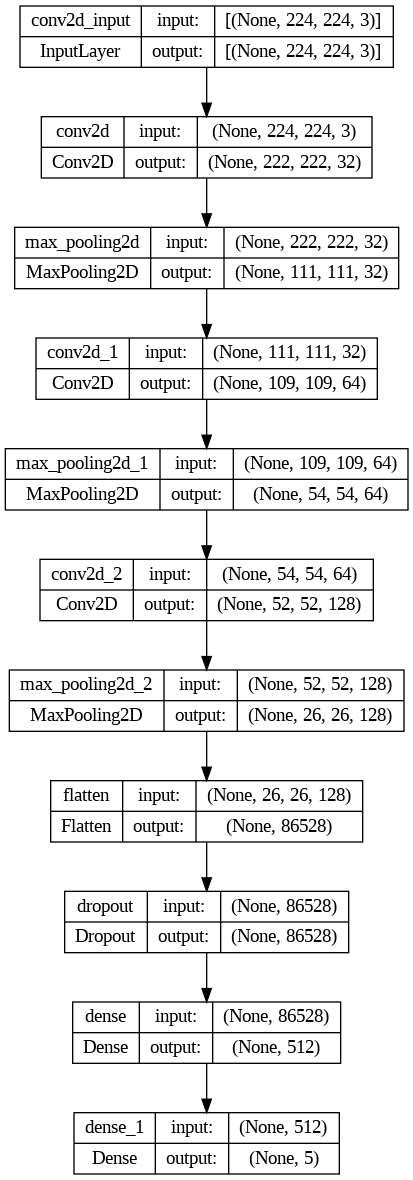

In [147]:
# Plot layers

tf.keras.utils.plot_model(model_aug, show_shapes=True)

### 7.2 Model Training

In [149]:
# Melatih model

%%time
history_aug = model_aug.fit(train_set_aug, epochs=20, validation_data=val_set_aug, batch_size=batch_size)

Epoch 1/20
188/188 [==============================] - 64s 333ms/step - loss: 0.4222 - accuracy: 0.8380 - val_loss: 0.1910 - val_accuracy: 0.9290
Epoch 2/20
188/188 [==============================] - 63s 333ms/step - loss: 0.2026 - accuracy: 0.9263 - val_loss: 0.1928 - val_accuracy: 0.9265
Epoch 3/20
188/188 [==============================] - 61s 326ms/step - loss: 0.1301 - accuracy: 0.9503 - val_loss: 0.0760 - val_accuracy: 0.9745
Epoch 4/20
188/188 [==============================] - 62s 328ms/step - loss: 0.1298 - accuracy: 0.9540 - val_loss: 0.2274 - val_accuracy: 0.9210
Epoch 5/20
188/188 [==============================] - 62s 328ms/step - loss: 0.1095 - accuracy: 0.9637 - val_loss: 0.1047 - val_accuracy: 0.9670
Epoch 6/20
188/188 [==============================] - 62s 328ms/step - loss: 0.1152 - accuracy: 0.9583 - val_loss: 0.1663 - val_accuracy: 0.9305
Epoch 7/20
188/188 [==============================] - 62s 330ms/step - loss: 0.1411 - accuracy: 0.9463 - val_loss: 0.1051 - val_ac

### 7.3 Model Evaluation

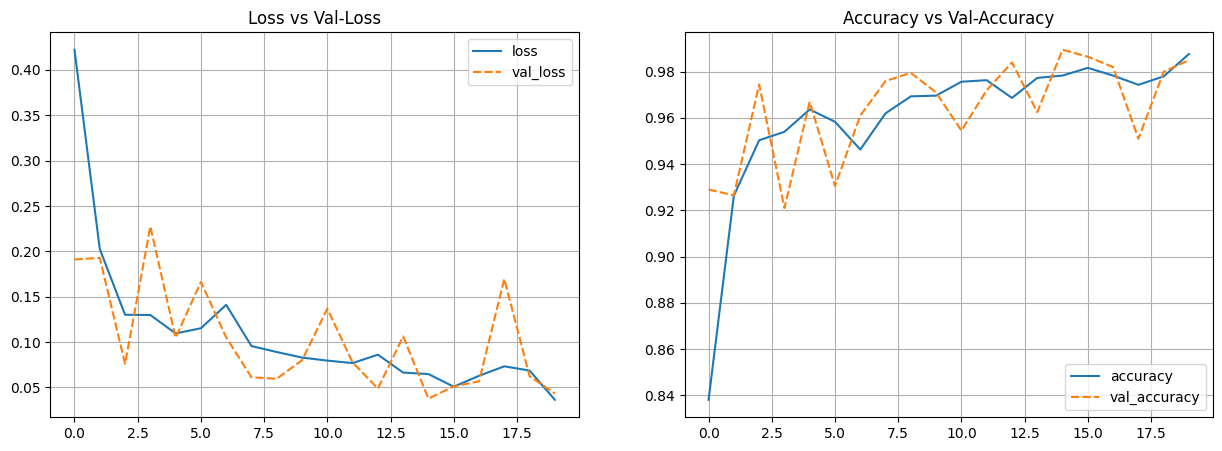

In [150]:
# Plot hasil training

history_aug_df = pd.DataFrame(history_aug.history)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.lineplot(data=history_aug_df[['loss', 'val_loss']])
plt.grid()
plt.title('Loss vs Val-Loss')

plt.subplot(1, 2, 2)
sns.lineplot(data=history_aug_df[['accuracy', 'val_accuracy']])
plt.grid()
plt.title('Accuracy vs Val-Accuracy')
plt.show()

In [161]:
# memeriksa performance of test-set

# mendapatkan prediksi 'probability'
y_pred_prob_aug = model_aug.predict_generator(test_set)

# menentukan kelas dengan 'maximum probability'
y_pred_class_aug = np.argmax(y_pred_prob_aug, axis=-1)

# Menampilkan Classification Report
print(classification_report(test_set_aug.classes, y_pred_class_aug, target_names=np.array(list(train_set_aug.class_indices.keys()))))

              precision    recall  f1-score   support

     arborio       0.99      1.00      0.99       250
     basmati       1.00      0.98      0.99       250
      ipsala       1.00      0.99      1.00       250
     jasmine       0.98      0.99      0.98       250
   karacadag       1.00      1.00      1.00       250

    accuracy                           0.99      1250
   macro avg       0.99      0.99      0.99      1250
weighted avg       0.99      0.99      0.99      1250



**Overal Analisis**    
dari model yang telah diaugment menunjukan bahwa ada peningkatan akurasi dari : 

- data yang ditraining lebih cepat dari sebelum nya dengan epoch = 20. Total training data membutuhkan 20 menit, walaupun bentuk parameter dimiliki lebih besar dari model sebelumnya. Hasil yang diberikan memuaskan. 
- akurasi yang didapatkan lebih baik dari sebelumnya dengan rata2 sebesar **0.99** hampir **100**. 
- hasi keseluruhan menunjukan **goodfit**, namun bisa dibilang **overfit**. Hasil grafik akurasi tidak stabil. 

Dari model ini menunjukan peningkatan masif, hasil hampir mendekati 100. Namun, hasil yang terlalu baik masih dikatakan belum layak, dikarenakan dianggap terlalu baik. Pada tahap ini saya akan melakukan improvement dengan menggunakan *Transfer Learning*.

## 8. ANN Improvement (Sequential API)

**Transfer Learning - VGG19**

pada tahap ini saya akan mencoba menggunakan model VGG19 untuk memiliki harapan mendapatkan nilai akurasi baik. 

- model komplek menggunakan layer sebanyak 47 dengan konsep banyaknya layer yang dimiliki maka lebih baik hasil model tersebut.
- dimensi yang digunakan adalah dengan jumlah 3x3 bertambah pada setiap layer. Dimensi yang digunakan pada filter ada `3`,`64`,`128`,`256`,dan `512`.

In [188]:
# Menentukan hyperparameters

img_height= 224
img_width= 224
batch_size= 64

In [174]:
# mengunduh model 'pretrained'

from keras.applications.vgg19 import VGG19, preprocess_input

pretrained_model = VGG19(weights='imagenet', include_top=False, input_shape=(img_height,img_width, 3))
pretrained_model.trainable = False

80134624/80134624 [==============================] - 5s 0us/step


### 8.1 Model Definition

In [189]:
# membuat batch generator untuk train-set, val-set, dan test-set

train_datagen_tl = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=20,
                                                                   zoom_range=0.05,
                                                                   width_shift_range=0.05,
                                                                   height_shift_range=0.05,
                                                                   shear_range=0.05,
                                                                   horizontal_flip=True,
                                                                   validation_split=0.4,
                                                                   preprocessing_function=preprocess_input)

train_set_tl = train_datagen_tl.flow_from_directory(train_path,
                                                    target_size=(img_height,img_width),
                                                    class_mode='sparse',
                                                    subset='training',
                                                    batch_size=batch_size,
                                                    shuffle=True,
                                                    seed=2)

val_set_tl = train_datagen_tl.flow_from_directory(train_path,
                                                  target_size=(img_height,img_width),
                                                  class_mode='sparse',
                                                  subset='validation',
                                                  batch_size=batch_size,
                                                  shuffle=True,
                                                  seed=2)

test_datagen_tl = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_input)

test_set_tl = test_datagen_tl.flow_from_directory(test_path,
                                                  target_size=(img_height,img_width),
                                                  class_mode='sparse',
                                                  batch_size=batch_size,
                                                  shuffle=False,
                                                  seed=2)

Found 3000 images belonging to 5 classes.
Found 2000 images belonging to 5 classes.
Found 1250 images belonging to 5 classes.


In [190]:
# sesi pembersihan model

seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

In [191]:
# membuat model Sequential API

model_tl_vgg19 = Sequential()
model_tl_vgg19.add(pretrained_model)
model_tl_vgg19.add(Flatten())
model_tl_vgg19.add(Dense(512, activation='relu'))
model_tl_vgg19.add(Dense(5, activation='softmax'))

# menggabungkan
model_tl_vgg19.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model_tl_vgg19.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 512)               12845568  
                                                                 
 dense_1 (Dense)             (None, 5)                 2565      
                                                                 
Total params: 32872517 (125.40 MB)
Trainable params: 12848133 (49.01 MB)
Non-trainable params: 20024384 (76.39 MB)
_________________________________________________________________


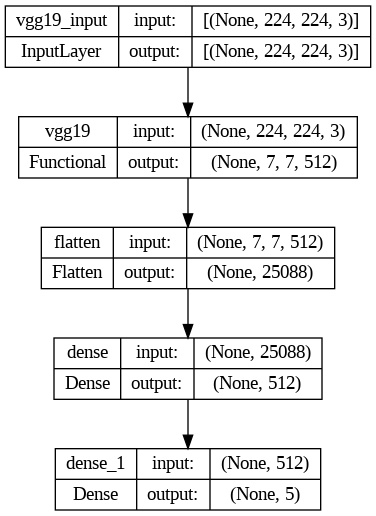

In [192]:
# Plot layers

tf.keras.utils.plot_model(model_tl_vgg19, show_shapes=True)

### 8.2 Model Training

In [193]:
# melatih model

%%time
history_tl = model_tl_vgg19.fit(train_set_tl, epochs=20, validation_data=val_set_tl, batch_size=batch_size)

Epoch 1/20
47/47 [==============================] - 68s 1s/step - loss: 5.6264 - accuracy: 0.8757 - val_loss: 0.1592 - val_accuracy: 0.9845
Epoch 2/20
47/47 [==============================] - 66s 1s/step - loss: 0.1592 - accuracy: 0.9860 - val_loss: 0.1754 - val_accuracy: 0.9875
Epoch 3/20
47/47 [==============================] - 66s 1s/step - loss: 0.1219 - accuracy: 0.9867 - val_loss: 0.3571 - val_accuracy: 0.9765
Epoch 4/20
47/47 [==============================] - 66s 1s/step - loss: 0.1246 - accuracy: 0.9900 - val_loss: 0.2296 - val_accuracy: 0.9835
Epoch 5/20
47/47 [==============================] - 66s 1s/step - loss: 0.1912 - accuracy: 0.9813 - val_loss: 0.2154 - val_accuracy: 0.9800
Epoch 6/20
47/47 [==============================] - 67s 1s/step - loss: 0.1975 - accuracy: 0.9833 - val_loss: 0.2361 - val_accuracy: 0.9875
Epoch 7/20
47/47 [==============================] - 65s 1s/step - loss: 0.0556 - accuracy: 0.9957 - val_loss: 0.1379 - val_accuracy: 0.9860
Epoch 8/20
47/47 [==

### 8.3 Model Evaluation

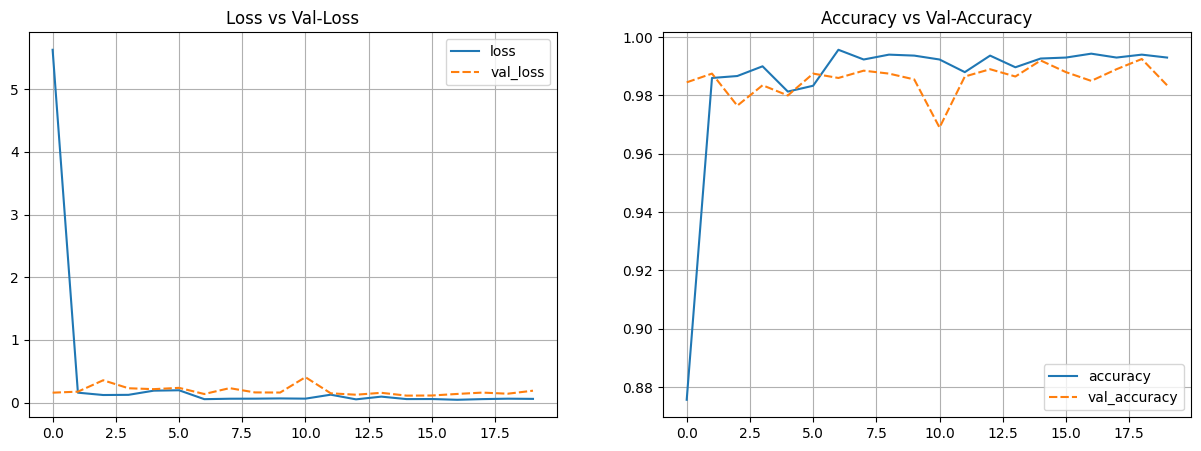

In [194]:
# Plot hasil training

history_tl_df = pd.DataFrame(history_tl.history)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.lineplot(data=history_tl_df[['loss', 'val_loss']])
plt.grid()
plt.title('Loss vs Val-Loss')

plt.subplot(1, 2, 2)
sns.lineplot(data=history_tl_df[['accuracy', 'val_accuracy']])
plt.grid()
plt.title('Accuracy vs Val-Accuracy')
plt.show()

In [195]:
# memeriksa performance of test-set

# mendapatkan "probability"
y_pred_prob_tl = model_tl_vgg19.predict_generator(test_set_tl)

## mendapatkan kelas "maximum probability"
y_pred_class_tl = np.argmax(y_pred_prob_tl, axis=-1)

## menampilkan Classification Report
print(classification_report(test_set_tl.classes, y_pred_class_tl, target_names=np.array(list(train_set_tl.class_indices.keys()))))

              precision    recall  f1-score   support

     arborio       0.96      0.99      0.98       250
     basmati       0.96      0.99      0.98       250
      ipsala       1.00      1.00      1.00       250
     jasmine       0.98      0.97      0.98       250
   karacadag       1.00      0.96      0.98       250

    accuracy                           0.98      1250
   macro avg       0.98      0.98      0.98      1250
weighted avg       0.98      0.98      0.98      1250



**Overal Analisis**   
dari model vgg19 menunjukan perubahan masif yaitu :   
- waktu data yang ditraining sama dengan model augmentasi, namun parameter yang dimiliki tidak banyak dari model sebelumnya. 
- akurasi overal menurun 1 persen, dan terjadi optimisasi terhadap akurasi pada kelima kelas. 
- hasil kesuluruhan jauh lebih baik, dapat dikatakan sebagai **goodfit** serta stabil. Akurasi dengan val lebih stabil, dan tidak cenderung **overfit**. 

Dari model ini dapat disimpulkan kestabilan dari sebuah model transfer learning bisa digunakan menjadi acuan prediksi. Hal ini dapat dilanjutkan untuk melakukan tahap deployment karena model sudah dikatakan bagus.

## 9. Model Saving

In [196]:
# Save the model
model_tl_vgg19.save('model_tl_vgg19.h5')

## 10. Model Inference

In [ ]:
# model inference
model = tf.keras.models.load_model('model_tl_vgg19.h5')

## 11. Pengambilan Kesimpulan

**Eksplorasi Data**
dari eksplorasi dapat disimpulkan bahwa, dapat ditemukan pengetahuan seperti : 

- Bentuk beras diketahui memiliki karakteristik yang berbeda, walaupun ada kemiripan pada dua kelas beras, namun masih menunjukan keunikan masing - masing. 
- Klasifikasi gambar tidak hanya menunjukan bentuk biji beras berbeda, namun warna setiap beras memiliki kecenderungan masing - masing. Seperti ipsala, dan arborio memiliki warna putih berani dibandingkan beras lainnya. Bentuk beras jasmine, dan basmati memiliki bentuk mirip, tetapi ukuran berbeda, serta
- karacadag dengan keunikan ukuran beras lebih mendekati bulat sempurna dibandingkan dengan beras lainnnya. 

**Model Analisis**

- model yang simpel pada gambar menjadikan akurasi paling tidak akurat, pembentuk kompleksitas data diperlukan untuk melatih model. Tentu saja dari tahap ini kemungkinan `model functional` sangat cocok untuk melakukan prediksi beras. Tetapi `sequential` masih berkinerja baik. model simpel juga memudahkan dalam melakukan penentuan parameter. Manipulasi data pada kasus ini diperlukan untuk identifikasi beras menjadi presisi terhadap gambar.
- pada akhir nya model pertama sangat tidak baik, namun model augment, dan vgg19 membantu menutupi kejanggalan tersebut. 

**Improvisasi**

- Melatih biji beras sebenarnya tidak cukup untuk mencapai prediksi yang diinginkan, dibutuhkan bentuk gambar tidak hanya biji beras satuan, namun beras secara kesuluruhan. Kompleksitas klasifikasi suatu gambar sangat diperlukan. 
- Optimisasi seperti menambah efek gambar, *shadder*, dan warna akan membantu melatih model, mungkin apabila tidak ada batasan waktu atau sumberdaya seperti alat perhitungan, atau grafik card(GPU) pada umumnya. Maka penambahan epoch dan batch dapat dilakukan. 
- banyak nya model transfer learning juga bisa dilakukan, dengan cara melakukan percobaan pada setiap model transfer learning. Optimisasi model terbaik dapat membantu melakukan prediksi gambar. 
- pada tahap lainnya melakukan prediksi hanya untuk beras bisa dilakukan, serta menambahkan opsi seperti "apabila bukan beras, maka model tidak dapat mendeteksi, atau prediksi hasil gambar tersebut".


Secara Keseluruhan model sudah dapat digunakan dengan baik, target objetivitas sudah mencapai kepuasan penelitian. Peningkatan ,atau penambahan data sangat diperlukan untuk memberikan prediksi model lebih detail dari sebelumnya.